In [24]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [82]:
class ProcessData():
    """Class for creating pandas dataframe and data exploration. Class expects a single organism MIC data file,
    as serialised python dictionary."""
    def __init__(self, organism_mic_data_path):
        """args:-
        organism_mic_data_filename: string - organism mic data pickle file path"""
        self.mic_data = pickle.load(open(organism_mic_data_path, 'rb'))
        self.mic_dataframe = self.build_dataframe()
        
    def build_dataframe(self):
        """Creates pandas dataframe using mic data from pickle file
        Returns dataframe object"""
        def add_to_row(drugMIC):
            """Creates dictionary object of format drugname:result from mic data dictionary values"""
            drugName = drugMIC['drug']
            #Antibiotic result can be of type MIC value, or an interpretation e.g. + or -
            if 'mic' in list(drugMIC.keys()):
                drugResult = drugMIC['mic']
            else:
                drugResult = drugMIC['interpretation']
            return {drugName: drugResult}
        df_rows = []
        #Loop through each isolate and create new row for dataframe. Then create dataframe from rows
        for isolate in self.mic_data:
            if isolate[]
            mic_data = isolate['isolate_data']['mic_data']    
            drug_mic_data = list(map(lambda x: add_to_row(x), mic_data))
            row = {drug:result for drugResult in drug_mic_data for drug,result in drugResult.items()}
            row['isolate_date'] = isolate['isolate_date']
            row['species'] = isolate['isolate_data']['organism_name']
            df_rows.append(row)
        df = pd.DataFrame.from_dict(df_rows)
        df.sort_values('isolate_date', inplace=True)
        df.set_index('isolate_date', inplace=True, drop=True)
        return df
        
    def get_dataframe(self):
        """Return pandas dataframe object"""
        return self.mic_dataframe
    
    def to_excel(self, path):
        """Save pandas dataframe object as excel file
        args:- 
        path: string - path to save file too"""
        self.mic_dataframe.to_excel(path)
    
    def antibiotic_series(self, antibiotic, remove_outliers=False):
        """Generate a pandas series object for specified antibiotic.
        args:-
        antibiotic: string - antibiotic of interest
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.mic_dataframe[antibiotic].copy()
        antibiotic_data = pd.to_numeric(antibiotic_data, errors='coerce')
        antibiotic_data.dropna(inplace=True)
        if remove_outliers != False:
            antibiotic_data = antibiotic_data[np.abs(antibiotic_data-antibiotic_data.mean())
                               <=(remove_outliers*antibiotic_data.std())]
        return antibiotic_data
    
    def antibiotic_descriptives(self, antibiotic, remove_outliers=False):
        """Return descriptive statistics for requested antibiotic
        args:-
        antibiotic: string - antibiotic of interest
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers)
        return {'Oldest data point': antibiotic_data.index.values[0],
               'Newest data point': antibiotic_data.index.values[antibiotic_data.shape[0]-1],
                'Total data points': antibiotic_data.count(),
               'Mean': antibiotic_data.mean(),
                'Standard dev': antibiotic_data.std(),
                'Min MIC': antibiotic_data.min(),
                'Max MIC': antibiotic_data.max(),
                'Median MIC': antibiotic_data.median(),
               'Sample variance': antibiotic_data.var(),
               'Skewness': antibiotic_data.skew(),
               'Kurtosis': antibiotic_data.kurt()}
    
    def antibiotic_distribution_curve(self, antibiotic, bins='auto', remove_outliers=False):
        """Generate distribution curve for selected antibiotic.
        args:-
        antibiotic: string - antibiotic of interest
        bins: integer/string - see numpy.histogram documentation for bins
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers).values
        hist, bins = np.histogram(antibiotic_data, bins=bins)
        fig,ax = plt.subplots(figsize=(10,5))
        ax.plot(bins[:-1], hist)
        plt.show()
        
    def antibiotic_timeseries(self, antibiotic, intervals='M', remove_outliers=False):
        """Generate timeseries with mean MIC value and standard deviations, using the time interval provided.
        args:-
        antibiotic: string - antibiotic of interest
        interval: integer/string - see pandas documentation
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        antibiotic_data = self.antibiotic_series(antibiotic, remove_outliers=remove_outliers)
        means = antibiotic_data.resample(intervals).mean().rename('Mean MIC')
        std = antibiotic_data.resample(intervals).std().rename('SD')
        return pd.concat([means,std], axis=1)
    
    def antibiotic_trend_analysis(self, antibiotic, intervals='M', include_sd=True, remove_outliers=False):
        """Generate trend line plot for mean MIC value over time, with line of best fit generated using 
        first degree polynomial regression.
        args:-
        antibiotic: string - antibiotic of interest
        interval: integer/string - see pandas documentation
        include_sd: boolean - include +/- 1 standard deviation either side of mean
        remove_outliers: integer - standard deviations either side of the mean to remain included in series data. 
        Default = False, will include all data."""
        fig,ax = plt.subplots(figsize=(10,5))
        timeseries = self.antibiotic_timeseries(antibiotic, intervals, remove_outliers=remove_outliers)
        timeseries.dropna(inplace=True)
        coefficients, residuals, _, _, _ = np.polyfit(range(len(timeseries.index)),timeseries['Mean MIC'],1,full=True)
        mse = residuals[0]/(len(timeseries.index))
        nrmse = np.sqrt(mse)/(timeseries['Mean MIC'].max() - timeseries['Mean MIC'].min())
        print('First degree polynomial regression -- Slope: {0:2.6}, Fitting error: {1:2.6}%'
              .format(np.round(coefficients[0], decimals=4), np.round(nrmse*100, decimals=6)))
        ax.plot(timeseries.index.values, timeseries['Mean MIC'])
        ax.plot(timeseries.index.values, [coefficients[0]*x + coefficients[1] for x in range(len(timeseries))])
        
        if include_sd:
            timeseries['SD +1'] = timeseries['Mean MIC'] + timeseries['SD']
            timeseries['SD -1'] = timeseries['Mean MIC'] - timeseries['SD']
            ax.plot(timeseries.index.values, timeseries['SD +1'])
            ax.plot(timeseries.index.values, timeseries['SD -1'])
        plt.show()
        
    def correlation_matrix(self, antibiotics='all', null_threshold=0.5):
        """Generate correlation matrix of all drug MIC values, and show as heatmap
        args:-
        antibiotics: list of strings - antibiotics to include in matrix
        null_threshold: float - the maximum percentage, taken as a percentage of dataset size, of null values
        a column can have without being excluded from correlation matrix"""
        if antibiotics == 'all':
            columns = self.mic_dataframe.columns.tolist()
        else:
            columns = antibiotics
            
        antibiotic_data = self.mic_dataframe[columns].copy()
        antibiotic_data = antibiotic_data.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
        antibiotic_data = antibiotic_data.loc[:, (antibiotic_data.isnull().sum(axis=0)/
                                                  antibiotic_data.shape[0] < null_threshold)]
        corr_matrix = antibiotic_data.corr()
        plt.figure(figsize=(18,15))
        sns.set(font_scale=1.5)
        cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
        sns.heatmap(corr_matrix, annot=False, cmap=cmap)
        plt.show()

In [85]:
staph_data = ProcessData('staph_mic_data.pickle')

In [86]:
staph_data.antibiotic_descriptives('Meropenem')

{'Kurtosis': 5.8378600312756213,
 'Max MIC': 8.0,
 'Mean': 1.5294117647058822,
 'Median MIC': 0.5,
 'Min MIC': 0.5,
 'Newest data point': numpy.datetime64('2017-04-23T00:00:00.000000000'),
 'Oldest data point': numpy.datetime64('2015-11-05T00:00:00.000000000'),
 'Sample variance': 4.202205882352941,
 'Skewness': 2.3697562297808124,
 'Standard dev': 2.049928262733343,
 'Total data points': 17}

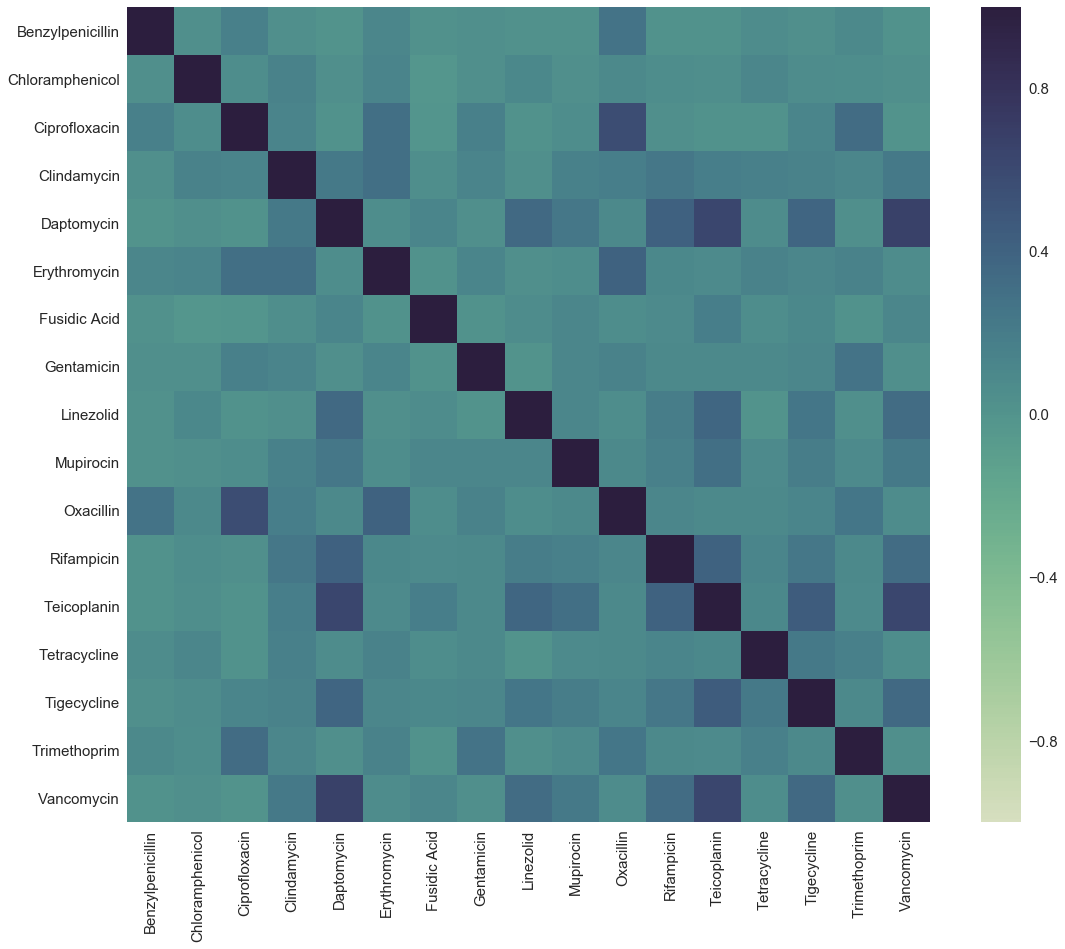

In [87]:
staph_data.correlation_matrix()

In [83]:
pyo_data = ProcessData('pyo_mic_data.pickle')

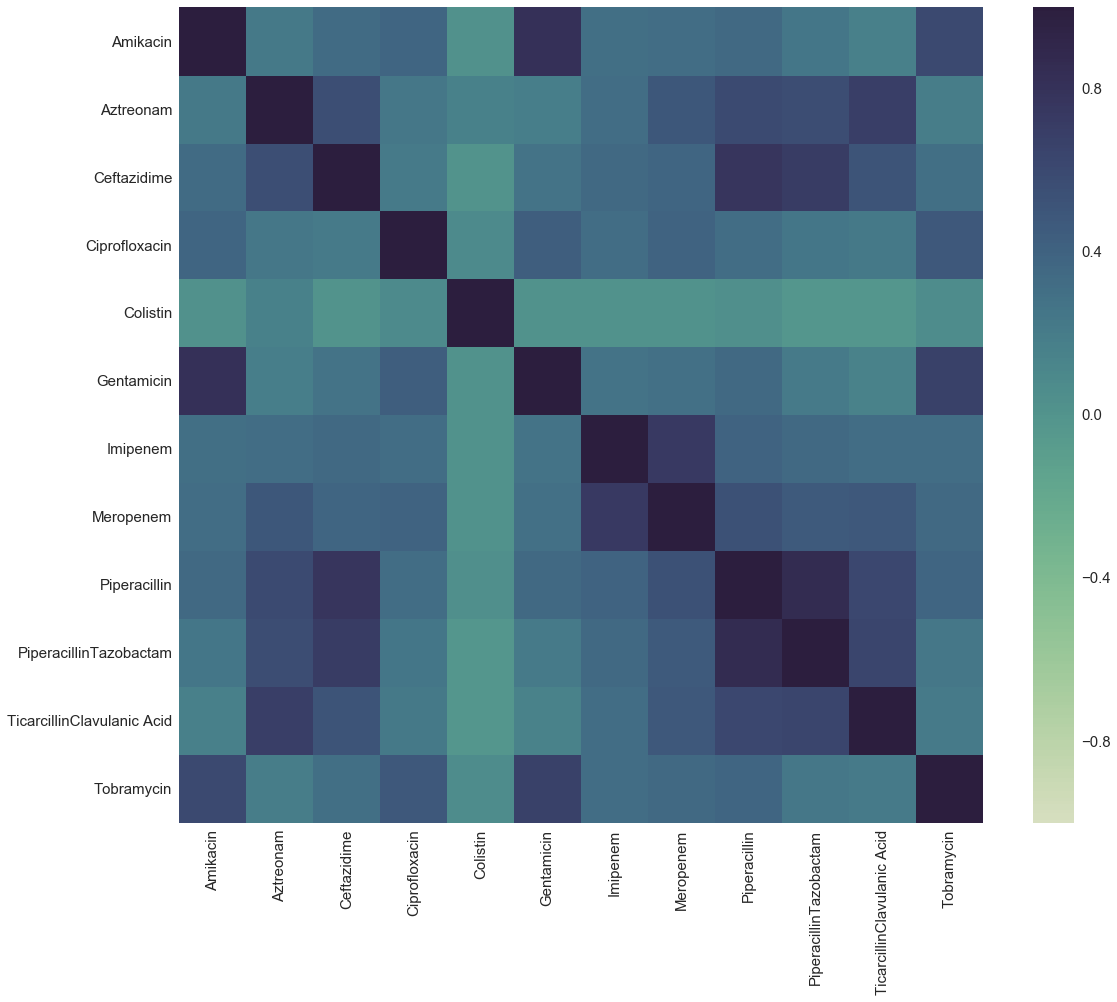

In [84]:
pyo_data.correlation_matrix()

In [24]:
pyo_mic_df = pyo_data.get_dataframe()

In [25]:
tzp_descriptives = pyo_data.antibiotic_descriptives('PiperacillinTazobactam')

In [26]:
tzp_descriptives

{'Kurtosis': 9.8917389454453968,
 'Max MIC': 128,
 'Mean': 15.453563159248779,
 'Median MIC': 8.0,
 'Min MIC': 4,
 'Newest data point': numpy.datetime64('2017-12-10T00:00:00.000000000'),
 'Oldest data point': numpy.datetime64('2015-03-10T00:00:00.000000000'),
 'Sample variance': 867.3945877895735,
 'Skewness': 3.3692401428814831,
 'Standard dev': 29.451563418426083,
 'Total data points': 3887}

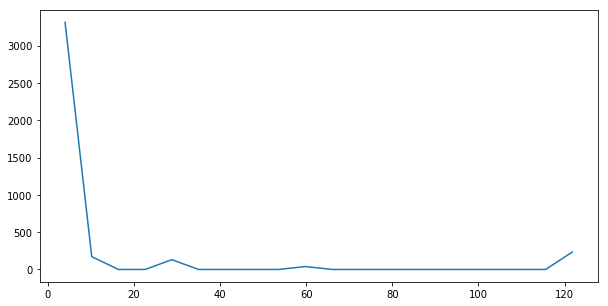

In [27]:
pyo_data.antibiotic_distribution_curve('PiperacillinTazobactam', bins=20)

In [28]:
pyo_data.antibiotic_timeseries('PiperacillinTazobactam')

,Mean MIC,SD
isolate_date,,
2015-03-31,15.736264,30.514417
2015-04-30,13.540984,23.360328
2015-05-31,21.937500,38.013622
2015-06-30,11.963636,23.571063
2015-07-31,15.295455,29.026947
2015-08-31,13.729167,25.060546
2015-09-30,NaN,NaN
2015-10-31,16.000000,31.532296
2015-11-30,13.272727,26.042922


First degree polynomial regression -- Slope: 0.2135, Fitting error: 22.3524%


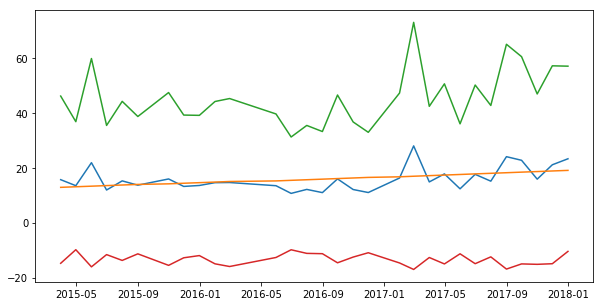

In [29]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam')

First degree polynomial regression -- Slope: 0.2135, Fitting error: 22.3524%


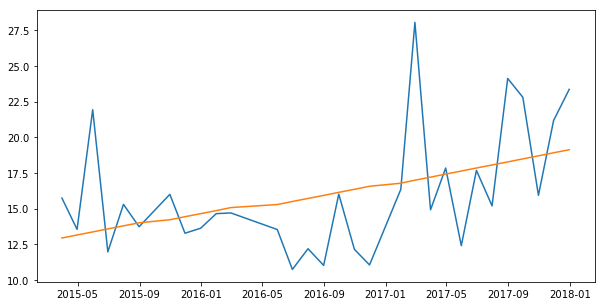

In [30]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam', include_sd=False)

<h3>Remove outliers</h3>

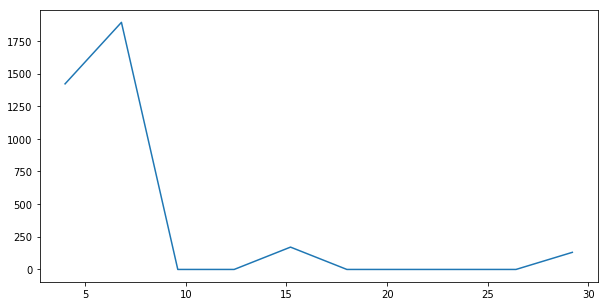

In [32]:
pyo_data.antibiotic_distribution_curve('PiperacillinTazobactam', bins=10, remove_outliers=1)

In [33]:
pyo_data.antibiotic_descriptives('PiperacillinTazobactam', remove_outliers=1)

{'Kurtosis': 11.363712846092875,
 'Max MIC': 32,
 'Mean': 7.675795297372061,
 'Median MIC': 8.0,
 'Min MIC': 4,
 'Newest data point': numpy.datetime64('2017-12-10T00:00:00.000000000'),
 'Oldest data point': numpy.datetime64('2015-03-10T00:00:00.000000000'),
 'Sample variance': 30.09298065537331,
 'Skewness': 3.209017942796951,
 'Standard dev': 5.485706942170108,
 'Total data points': 3615}

First degree polynomial regression -- Slope: 0.0348, Fitting error: 19.47%


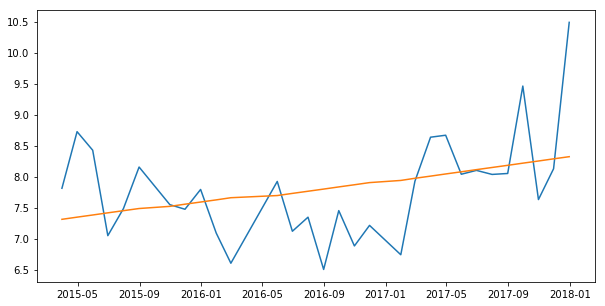

In [34]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam', include_sd=False, remove_outliers=1)

First degree polynomial regression -- Slope: 0.0348, Fitting error: 19.47%


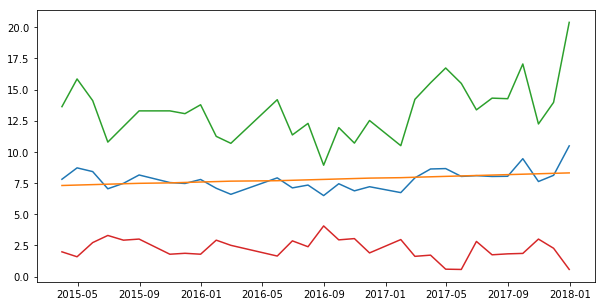

In [35]:
pyo_data.antibiotic_trend_analysis('PiperacillinTazobactam', include_sd=True, remove_outliers=1)